<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/efficientnet_introduction_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [ ]:
import tensorflow_datasets as tfds

# For more info bout TFDT: https://www.tensorflow.org/datasets/overview

batch_size = 64

# By using as_supervised=True, you can get a tuple (features, label) instead for supervised datasets.

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [7]:
import tensorflow as tf

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [21]:
single_example = ds_train.take(1)  # Only take a single example
print(single_example)
for (image, label) in single_example:
  print(image.shape)
  print(ds_info.features["label"].int2str(label))

<TakeDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
(224, 224, 3)
n02094433-yorkshire_terrier


In [ ]:
print(ds_info)

In [ ]:
print(ds_info.features)
print(dir(ds_info.features["label"])) # See 'int2str', 'str2int', 'names', 'num_classes' among others
# Print label names
print(ds_info.features["label"].names)

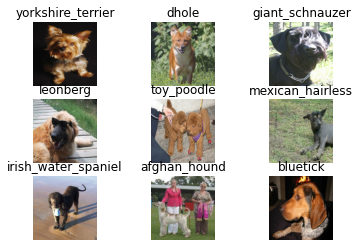

In [32]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]

for i, (image, label) in enumerate(ds_train.take(9)): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [34]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

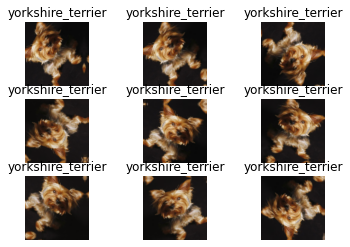

In [35]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [36]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 2  # @param {type: "slider", min:1, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

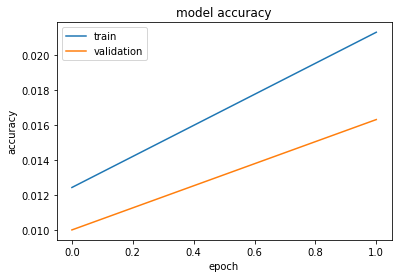

In [39]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [40]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [42]:
model.save('/content/efficientnet_dogs.h5')

In [43]:
from google.colab import files
files.download('/content/efficientnet_dogs.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving efficientnet_dogs.h5 to efficientnet_dogs.h5


In [2]:
from tensorflow import keras
enet_model = keras.models.load_model('/content/efficientnet_dogs.h5')

In [ ]:
print(enet_model.summary())

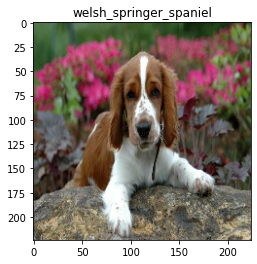

In [16]:
import matplotlib.pyplot as plt
import cv2

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]

example = ds_test.take(1)

for (image, label) in example:
  plt.figure()
  img = image.numpy().astype("uint8")
  cv2.imwrite("test_img.png", img)
  plt.imshow(img)
  plt.title("{}".format(format_label(label)))
  plt.grid(False)
  plt.show()

In [18]:
# enet_model.predict(ds_test.take(1))
img_test = cv2.imread("test_img.png")
print(img_test.shape)

(224, 224, 3)


In [ ]:
import numpy as np

img_test = np.reshape(img_test,[1,224,224,3])
predictions = enet_model.predict(img_test)
print(predictions.shape)
print(predictions)

In [24]:
print(np.argmax(predictions[0]))

67


In [30]:
string_label = label_info.int2str(np.argmax(predictions[0]))
print(string_label)

n02102177-welsh_springer_spaniel
